In [2]:
import numpy as np
import torch
from torchmetrics.classification import MultilabelConfusionMatrix
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns
from matplotlib import pyplot as plt

In [65]:
class_names = [
    "angiectasia", "angiodysplasia", "barretts-esophagus", "cancer",
    "diverticulum", "erythema", "esophagitis", "normal-mucosa",
    "stenosis", "submucosal-tumor", "ulcer", "varices"
]
num_classes = len(class_names)

In [66]:
labels = []
for i in range(100):  # Simulate data for 100 instances
    label = np.zeros(num_classes)
    chosen_classes = np.random.choice(range(num_classes), np.random.randint(1, 4), replace=False)
    label[chosen_classes] = 1
    labels.append(label)

# Adjust frequency manually for illustrative purposes
for i in range(num_classes):
    if i % 4 == 3:  # Reduce frequency of every fourth class
        for j in range(len(labels)):
            if np.random.rand() < 0.8:  # 80% chance to turn off the label
                labels[j][i] = 0

labels = np.array(labels)
preds = np.random.rand(100, num_classes)  # Predictions as random probabilities

# Convert labels to int for PyTorch compatibility
labels = labels.astype(int)

In [308]:
def create_multilabel_conf_matrix(labels, preds, val_mAP_weighted=None, epoch=None):
    sns.set_style("white")
    sns.set_context("paper")

    conf_mat = MultilabelConfusionMatrix(num_labels=num_classes)
    all_preds, all_labels = torch.tensor(preds, dtype=torch.float), torch.tensor(labels, dtype=torch.int)
    conf_mat.update(preds=all_preds, target=all_labels)
    cm = conf_mat.compute().numpy()  # Shape: [num_labels, 2, 2]

    # Plot confusion matrices for each label
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(14, 10), squeeze=False)
    axes = axes.flatten()

    for i in range(num_classes):
        thresh = 40
        ax = axes.flatten()[i]
        cm_label = cm[i]  # Get the 2x2 confusion matrix for label i

        cm_normalized = (cm_label.astype('float') / cm_label.sum()) * 100
        norm = TwoSlopeNorm(vmin=0, vcenter=thresh, vmax=100)
        cax = ax.imshow(cm_normalized, interpolation='nearest', cmap='Blues', norm=norm)

        # Set axes titles
        ax.set_title(class_names[i], fontsize=14, weight='bold', pad=10)
        
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_xticklabels(['Pos', 'Neg'], fontsize=12)
        ax.set_yticklabels(['Pos', 'Neg'], fontsize=12, rotation=90, va='center') 
        ax.tick_params(axis='x', which='major', pad=0)
        ax.tick_params(axis='y', which='major', pad=0)


        # Simplify annotations
        fmt = 'd'
        for j in range(2):
            for k in range(2):
                ax.text(k, j, format(cm_label[j, k], fmt),
                        ha="center", va="center",
                        color="white" if cm_normalized[j, k] > thresh else "black",
                        fontsize=10)
                
    # Global axes labels
    fig.text(0.52, 0.11, 'Prediction', ha='center', va='center', fontsize=20)
    fig.text(0.11, 0.52, 'Ground Truth', ha='center', va='center', rotation='vertical', fontsize=20)

    # Add a single color bar on the right side
    cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.75]) 
    cbar = fig.colorbar(cax, cax=cbar_ax)
    cbar.set_label('Percentage', fontsize=20)
    cbar.ax.tick_params(labelsize=14)
    cbar.set_ticks([0, 20, 40, 60, 80, 100])
    cbar.set_ticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
    
    current_epoch = 99
    val_mAP_weighted = (0.8173) * 100
    fig.suptitle(f'Confusion Matrix (Epoch={current_epoch}; val_mAP_weighted={val_mAP_weighted:.2f})', fontsize=18, weight='bold')

    plt.subplots_adjust(left=0.15, right=0.88, bottom=0.15, top=0.9, wspace=0.4)
    
    return fig

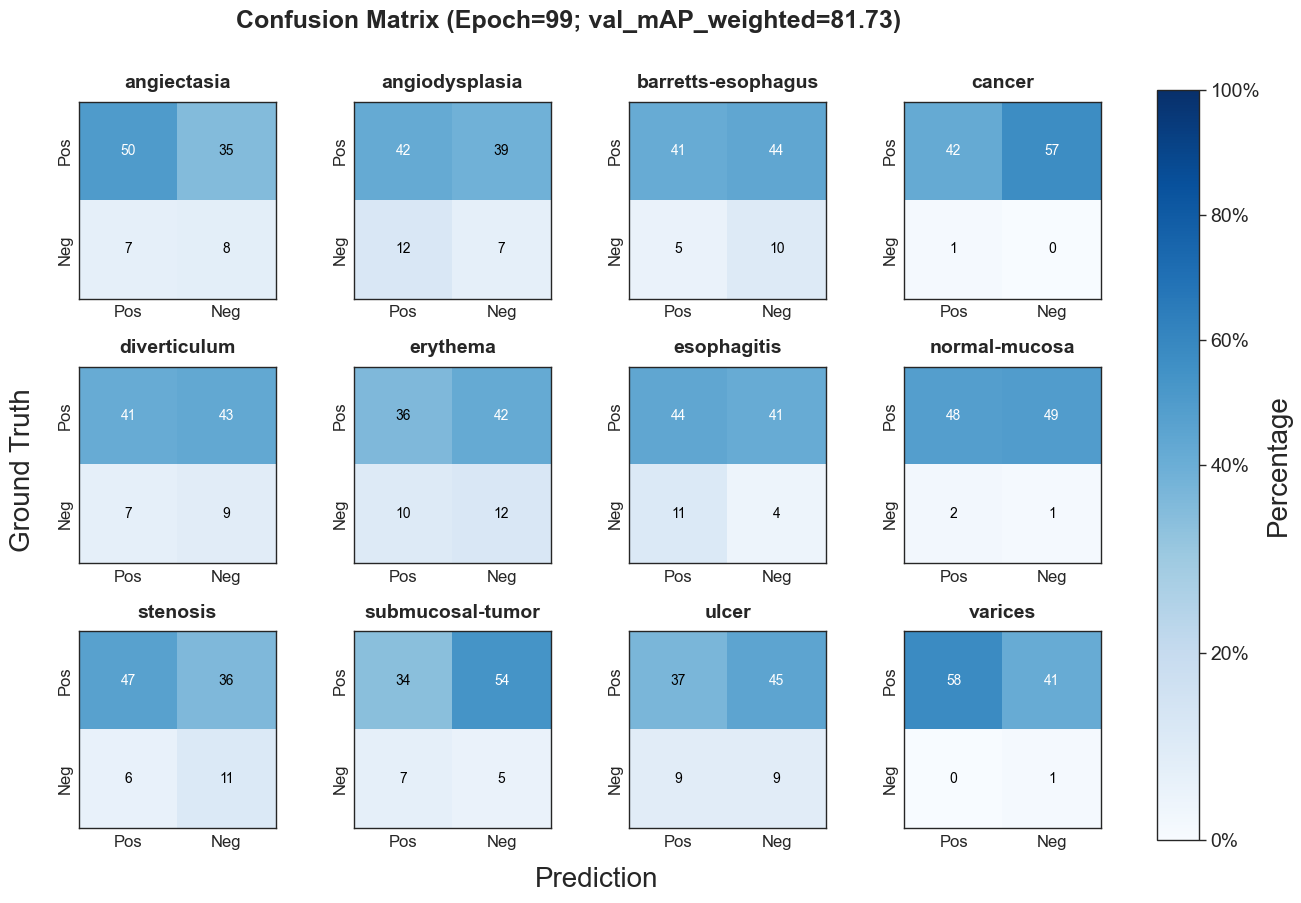

In [307]:
fig = create_multilabel_conf_matrix(labels=labels, preds=preds)
plt.show()